# A demonstration of basic EcotoxSystems.jl functionality

In [2]:
using DrWatson 
using Pkg; Pkg.activate("./../test")

  Activating project at `c:\Users\simon\Documents\EcotoxSystems.jl\test`


In [3]:
using EcotoxSystems
using Distributions
using DataFrames
using Plots, Plots.Measures 
using StatsPlots

## Running the default model

In [4]:
p = deepcopy(EcotoxSystems.defaultparams)
p.glb.t_max = 21.
sim = EcotoxSystems.ODE_simulator(p)
first(sim, 5)

Row,t,X,C_W_1,N,embryo,juvenile,adult,X_emb,S,H,R,f_X,I_emb,I_p,I,A,M,J,D_z_1_1,D_z_1_2,D_z_1_3,D_z_1_4,D_h_1,y_T,y_z_1_1,y_z_1_2,y_z_1_3,y_z_1_4,y_j_1_1,y_j_1_2,y_j_1_3,y_j_1_4,h_z,S_z,S_max_hist,id,cohort,age,cause_of_death,time_since_last_repro,cum_repro
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,1200.0,0.0,1.0,1.0,0.0,0.0,19.42,0.01942,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2400.0,0.0,1.0,1.0,0.0,0.0,4.25912,1.88236,1.98108,0.0,0.979586,0.0,0.0,15.1609,5.00309,0.367992,0.325346,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3541.61,0.0,1.0,0.000202976,0.999797,0.0,-0.0868843,8.55771,8.99442,0.0,0.985591,0.0,0.0,77.8994,25.7068,3.18309,2.85641,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0
4,3.0,4610.19,0.0,1.0,5.51897e-5,0.999945,0.0,-0.0986449,20.5827,21.518,0.0,0.989112,0.0,0.0,209.325,69.0773,11.5285,10.3266,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0
5,4.0,5599.06,0.0,1.0,2.81384e-5,0.999972,0.0,-0.106104,37.1552,38.643,0.0,0.990833,0.0,0.0,420.463,138.753,28.3679,25.3219,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
sim = DataFrame()
let Tvec = [17.5, 20., 22.5] # simulate three ambient temperatures
    for T in Tvec
        p.glb.T = 273.15 + T # succesively lower the food input rate
        sim_i = EcotoxSystems.ODE_simulator(p) # generate the predidction
        sim_i[!,:T] .= T
        append!(sim, sim_i) 
    end
end

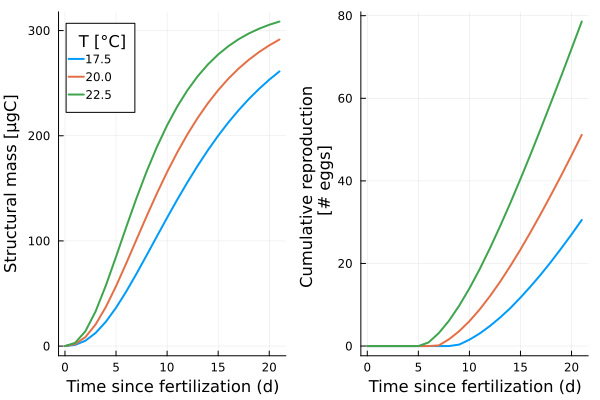

In [6]:
using StatsPlots

fig1 = @df sim plot(
    plot(:t, :S, group = :T, legendtitle = "T [°C]"), 
    plot(:t, trunc.(:R) ./ p.spc.X_emb_int, group = :T, leg = false), 
    lw = 2, 
    xlabel = "Time since fertilization (d)", 
    ylabel = ["Structural mass [μgC]" "Cumulative reproduction \n [# eggs]"]
)

savefig(plot(fig1, dpi = 400), "fig1.png")

fig1

## Individual-based simulation

In [21]:
using Distributions, ProgressMeter

p = deepcopy(EcotoxSystems.defaultparams)

# adjusting global parameters

p.glb.t_max = 365. # simulated timespan [d]
p.glb.V_patch = 0.5 # simulated volume [L]

# adjusting species-level parameters

p.spc.Z = Truncated(Normal(1, 0.1), 0, Inf) # induce individual variability 
p.glb.dX_in = 10_000 # provide more food 
p.spc.S_rel_crit = 0.66
p.spc.h_S = -log(0.5)

# simulating population dynamics across temepratures

sims = [] # initialize output data frame
    let Tvec = [17.5, 20., 22.5]
    for (i,T) in enumerate(Tvec) # iterate over temepratures
        p.glb.T = 273.15 + T # update temperature in Kelvin
        sim_i = @replicates EcotoxSystems.IBM_simulator(p, showinfo = Inf) 10 # run replicated simulations
        sim_i.glb[!,:T] .= p.glb.T # add column indicating temperature to global output dataframe
        sim_i.spc[!,:T] .= p.glb.T # add column indicating temperature to species-level output dataframe
        push!(sims, sim_i) 
    end
end
sims = EcotoxSystems.combine_outputs(Vector{typeof(sims[1])}(sims));

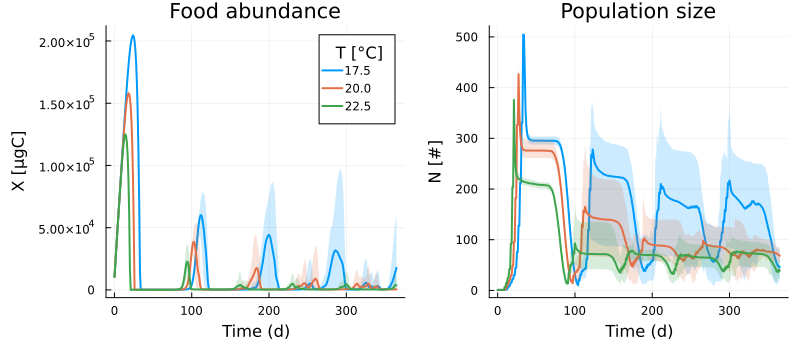

In [19]:
using Plots.Measures

plt = plot(
    (@df sims.glb groupedlineplot(:t, :X, :T, xlabel = "Time (d)", ylabel = "X [μgC]", label = hcat(unique(:T .- 273.15)...), legendtitle = "T [°C]")), 
    (@df sims.glb groupedlineplot(:t, :N, :T, xlabel = "Time (d)", ylabel = "N [#]", leg = false)), 
    #(@df sims.spc groupedlineplot(:t, :S, :T, xlabel = "Time (d)", ylabel = "S [μgC]", leg = false)),
    size = (800,350), title = ["Food abundance" "Population size" "Body mass"], lw = 2, fillalpha = .2, 
    bottommargin = 5mm, leftmargin= 5mm
)

savefig(plot(plt, dpi = 300), "Fig2.png")
plt